In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_squared_error,
    r2_score,
    mean_absolute_error
)
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')


In [ ]:
!pip install gdown
import gdown

In [ ]:
file_id = "1RvRhXLmF-kwI-8fHHPD1-RC-WzEUUxmz"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.csv"   # name to save locally
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1RvRhXLmF-kwI-8fHHPD1-RC-WzEUUxmz
From (redirected): https://drive.google.com/uc?id=1RvRhXLmF-kwI-8fHHPD1-RC-WzEUUxmz&confirm=t&uuid=60eb7cc7-cc13-4472-b304-b9af1fadddd0
To: /content/dataset.csv
100%|██████████| 294M/294M [00:03<00:00, 75.9MB/s]


'dataset.csv'

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,PREV_SK_ID_PREV_COUNT,PREV_SK_ID_CURR_FIRST,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MEDIAN,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MEDIAN,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MEDIAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MEDIAN,PREV_NAME_CONTRACT_TYPE_<LAMBDA>,PREV_WEEKDAY_APPR_PROCESS_START_<LAMBDA>,PREV_NAME_CASH_LOAN_PURPOSE_<LAMBDA>,PREV_NAME_CONTRACT_STATUS_<LAMBDA>,PREV_NAME_PAYMENT_TYPE_<LAMBDA>,PREV_CODE_REJECT_REASON_<LAMBDA>,PREV_NAME_CLIENT_TYPE_<LAMBDA>,PREV_NAME_GOODS_CATEGORY_<LAMBDA>,PREV_NAME_PORTFOLIO_<LAMBDA>,PREV_NAME_PRODUCT_TYPE_<LAMBDA>,PREV_CHANNEL_TYPE_<LAMBDA>,PREV_NAME_SELLER_INDUSTRY_<LAMBDA>,PREV_NAME_YIELD_GROUP_<LAMBDA>,PREV_PRODUCT_COMBINATION_<LAMBDA>,PREV_NFLAG_LAST_APPL_IN_DAY_MAX,PREV_NFLAG_INSURED_ON_APPROVAL_MAX,PREV_CNT_PAYMENT_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_SELLERPLACE_AREA_MEAN,PREV_YEARS_DECISION_MEAN,PREV_YEARS_FIRST_DRAWING_MEAN,PREV_YEARS_FIRST_DUE_MEAN,PREV_YEARS_LAST_DUE_1ST_VERSION_MEAN,PREV_YEARS_LAST_DUE_MEAN,PREV_YEARS_TERMINATION_MEAN,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,0.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25.902806,1.744011,9.987680,5.804244,3.104723,1.0,100002.0,9251.775,9251.7750,179055.00,179055.0,179055.00,179055.0,179055.00,179055.0,Consumer loans,SATURDAY,XAP,Approved,XNA,XAP,New,Vehicles,POS,XNA,Stone,Auto technology,low_normal,POS other with interest,1.0,0.0,24.0,9.000000,500.000000,1.659138,999.980835,1.546886,0.342231,0.068446,0.046543,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,0.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,0.544235,1.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45.900068,3.252567,3.247091,0.796715,2.266940,3.0,100003.0,56553.990,64567.6650,435436.50,337500.0,484191.00,348637.5,435436.50,337500.0,Consumer loans,FRIDAY,XAP,Approved,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,Consumer electronics,middle,Cash X-Sell: low,1.0,1.0,12.0,14.666667,533.000000,3.572895,999.980835,3.488935,2.749715,2.886607,2.867442,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,

In [ ]:
df_processed = data.copy()

# Separate target variable
# IMPORTANT: Replace 'target_column_name' with your actual target column name
target_column = input("\nEnter the name of your target column: ")

if target_column not in df_processed.columns:
    print(f"Error: Column '{target_column}' not found!")
    print(f"Available columns: {df_processed.columns.tolist()}")
else:
    y = df_processed[target_column]
    X = df_processed.drop(columns=[target_column])

    print(f"\n✓ Target variable: {target_column}")
    print(f"  Shape: {y.shape}")
    print(f"  Unique values: {y.nunique()}")

    # Determine if classification or regression
    is_classification = y.nunique() < 20 and y.dtype in ['object', 'int64']
    task_type = "Classification" if is_classification else "Regression"
    print(f"  Task type: {task_type}")


Enter the name of your target column: TARGET

✓ Target variable: TARGET
  Shape: (329925,)
  Unique values: 2
  Task type: Classification


In [ ]:
    # Identify categorical columns in features
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    if cat_features:
        print(f"Encoding {len(cat_features)} categorical columns: {cat_features}")

        # Use Label Encoding for all categorical features
        label_encoders = {}
        for col in cat_features:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
            print(f"  ✓ {col}: {len(le.classes_)} unique categories")

        print(f"\n✓ All categorical variables encoded!")
    else:
        print("No categorical variables found in features.")

    # Encode target if classification with string labels
    if is_classification and y.dtype == 'object':
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y)
        print(f"\n✓ Target variable encoded: {len(target_encoder.classes_)} classes")
        print(f"  Class mapping: {dict(zip(target_encoder.classes_, range(len(target_encoder.classes_))))}")

Encoding 26 categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'PREV_NAME_CONTRACT_TYPE_<LAMBDA>', 'PREV_WEEKDAY_APPR_PROCESS_START_<LAMBDA>', 'PREV_NAME_CASH_LOAN_PURPOSE_<LAMBDA>', 'PREV_NAME_CONTRACT_STATUS_<LAMBDA>', 'PREV_NAME_PAYMENT_TYPE_<LAMBDA>', 'PREV_CODE_REJECT_REASON_<LAMBDA>', 'PREV_NAME_CLIENT_TYPE_<LAMBDA>', 'PREV_NAME_GOODS_CATEGORY_<LAMBDA>', 'PREV_NAME_PORTFOLIO_<LAMBDA>', 'PREV_NAME_PRODUCT_TYPE_<LAMBDA>', 'PREV_CHANNEL_TYPE_<LAMBDA>', 'PREV_NAME_SELLER_INDUSTRY_<LAMBDA>', 'PREV_NAME_YIELD_GROUP_<LAMBDA>', 'PREV_PRODUCT_COMBINATION_<LAMBDA>']
  ✓ NAME_CONTRACT_TYPE: 2 unique categories
  ✓ CODE_GENDER: 3 unique categories
  ✓ FLAG_OWN_CAR: 2 unique categories
  ✓ FLAG_OWN_REALTY: 2 unique categories
  ✓ NAME_TYPE_SUITE: 7 unique categories
  ✓ NAME_INC

In [ ]:
    # Note: Random Forests don't strictly require scaling, but it helps with:
    # - Consistent feature importance interpretation
    # - Faster convergence in some cases
    # - Better compatibility if you later ensemble with other models

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    print("✓ Features standardized (mean=0, std=1)")
    print(f"  Original range: {X.min().min():.2f} to {X.max().max():.2f}")
    print(f"  Scaled range: {X_scaled.min().min():.2f} to {X_scaled.max().max():.2f}")

✓ Features standardized (mean=0, std=1)
  Original range: -1.00 to 4050000.00
  Scaled range: -122.46 to 574.39


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=0.2,
        random_state=42,
        stratify=y if is_classification else None
    )
print(f"✓ Data split completed:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Features: {X_train.shape[1]}")

✓ Data split completed:
  Training set: 263940 samples
  Test set: 65985 samples
  Features: 108


In [ ]:
# Train baseline model
baseline_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("\nTraining baseline model...")
baseline_model.fit(X_train, y_train)

# Baseline predictions
y_train_pred_baseline = baseline_model.predict(X_train)
y_test_pred_baseline = baseline_model.predict(X_test)

# Baseline metrics
baseline_train_acc = accuracy_score(y_train, y_train_pred_baseline)
baseline_test_acc = accuracy_score(y_test, y_test_pred_baseline)

print(f"\n✓ Baseline Training Accuracy: {baseline_train_acc:.4f}")
print(f"✓ Baseline Test Accuracy: {baseline_test_acc:.4f}")
print(f"  Overfitting Gap: {baseline_train_acc - baseline_test_acc:.4f}")

if baseline_train_acc - baseline_test_acc > 0.1:
    print("  ⚠️  Significant overfitting detected - will focus on regularization")


Training baseline model...


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Define model
rf = RandomForestClassifier(random_state=42)

# Define parameter space
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized search
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,              # number of random combinations
    cv=2,                   # 5-fold cross-validation
    scoring='accuracy',     # or 'f1', 'roc_auc' depending on task
    random_state=42,
    n_jobs=-1               # use all cores for speed
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [ ]:
final_rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=30,
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report


y_pred = final_rf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_pred = final_rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Train Accuracy: 0.9999280139425627
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146634
           1       1.00      1.00      1.00    117306

    accuracy                           1.00    263940
   macro avg       1.00      1.00      1.00    263940
weighted avg       1.00      1.00      1.00    263940

Test Accuracy: 0.9394104720769872
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     36658
           1       0.99      0.87      0.93     29327

    accuracy                           0.94     65985
   macro avg       0.95      0.93      0.94     65985
weighted avg       0.94      0.94      0.94     65985



Confusion Matrix:
 [[36434   224]
 [ 3774 25553]]


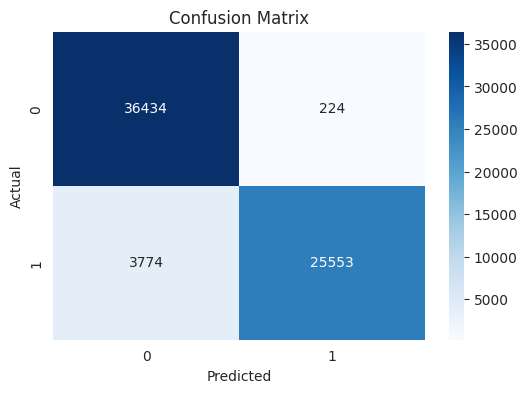

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import joblib

# Save directly to Google Drive
joblib.dump(final_rf, "/content/drive/MyDrive/best_random_forest.pkl")

['/content/drive/MyDrive/best_random_forest.pkl']